In [1]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

# from strawberryfields import ops
from strawberryfields.ops import Dgate, BSgate, Sgate, Rgate, Pgate

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle
from sklearn import datasets
import numpy as np

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
def visualize_dataset(trainX, trainY) -> None:
    fig, axs = plt.subplots(nrows=4, ncols=4)

    colors = ['red', 'blue', 'green']
    test_colors = ['purple', 'black', 'yellow']

    for i in range(4):
        for j in range(4):
            for k in np.unique(trainY, axis=0):
                axs[i % 4, j % 4].plot(trainX[trainY == k, i],
                                       trainX[trainY == k, j],
                                       'o', label='class {}'.format(k), color=colors[k]
                                       )

#                 axs[i % 4, j % 4].plot(testX[testY == k, i],
#                                        testX[testY == k, j],
#                                        'o', label='test_class {}'.format(k), color=test_colors[k]
#                                        )

                axs[i % 4, j % 4].legend(fontsize=5,
                                         ncol=1,
                                         facecolor='oldlace',
                                         edgecolor='r'
                                         )

                # axs[i % 4, j % 4].set_xlim(-1, 10)
                # axs[i % 4, j % 4].set_ylim(-1, 10)

    fig.set_size_inches(10., 6.5)
    plt.show()

In [3]:
def create_dataset():

    iris = datasets.load_iris()
    x = iris.data
    Y = iris.target
    
    y = []
    for i in range(len(Y)):
        if Y[i] == 0:
            y.append(0)
        elif Y[i] == 1:
            y.append(1)
        elif Y[i] == 2:
            y.append(2)

    x, y = shuffle(x, np.array(y), random_state=7)
    
    sep = round(len(x) * 0.1)
    
    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    return train_x, train_y, test_x, test_y

In [4]:
steps = 700
batch_size = 2


def circuit(X):

    params = [make_param(name='phi'+str(i), constant=.5, monitor=True) for i in range(46)]

    eng, q = sf.Engine(4)

    with eng:
        Sgate(1.5, X[:, 0]) | q[0]
        Sgate(1.5, X[:, 1]) | q[1]
        Sgate(1.5, X[:, 2]) | q[2]
        Sgate(1.5, X[:, 3]) | q[3]
        BSgate(params[0], params[1]) | (q[0], q[1])
        BSgate(params[2], params[3]) | (q[2], q[3])
        BSgate(params[4], params[5]) | (q[1], q[2])
        BSgate(params[6], params[7]) | (q[0], q[1])
        BSgate(params[9], params[8]) | (q[2], q[3])
        BSgate(params[10], params[11]) | (q[1], q[2])
        Rgate(params[12]) | q[0]
        Rgate(params[13]) | q[1]
        Rgate(params[14]) | q[2]
        Sgate(params[15]) | q[0]
        Sgate(params[16]) | q[1]
        Sgate(params[17]) | q[2]
        Sgate(params[18]) | q[3]
        BSgate(params[19], params[20]) | (q[0], q[1])
        BSgate(params[21], params[22]) | (q[2], q[3])
        BSgate(params[23], params[24]) | (q[1], q[2])
        BSgate(params[25], params[26]) | (q[0], q[1])
        BSgate(params[27], params[28]) | (q[2], q[3])
        BSgate(params[29], params[30]) | (q[1], q[2])
        Rgate(params[31]) | q[0]
        Rgate(params[32]) | q[1]
        Rgate(params[33]) | q[2]
        Dgate(params[34]) | q[0]
        Dgate(params[35]) | q[1]
        Dgate(params[36]) | q[2]
        Dgate(params[37]) | q[3]
        Pgate(params[38]) | q[0]
        Pgate(params[39]) | q[1]
        Pgate(params[40]) | q[2]
        Pgate(params[41]) | q[3]

    num_inputs = X.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

    p0 = state.fock_prob([2, 0, 0, 0])
    p1 = state.fock_prob([0, 2, 0, 0])
    p2 = state.fock_prob([0, 0, 2, 0])
    normalization = p0 + p1 + p2 + 1e-10
    circuit_output = [p0 / normalization, p1 / normalization, p2 / normalization]

    return circuit_output

def transform_to_binary(tensor):
    pass


def myloss(circuit_output, targets):
#     return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)
#     circuit_labels = tf.map_fn(tf.arg_max, circuit_output, dtype = tf.float64)
    return  tf.losses.softmax_cross_entropy(logits=tf.cast(tf.arg_max(circuit_output, 0), tf.float32), onehot_labels=tf.transpose(targets))


def outputs_to_predictions(outpt):
    print(tf.transpose(output))
    return tf.round(outpt)

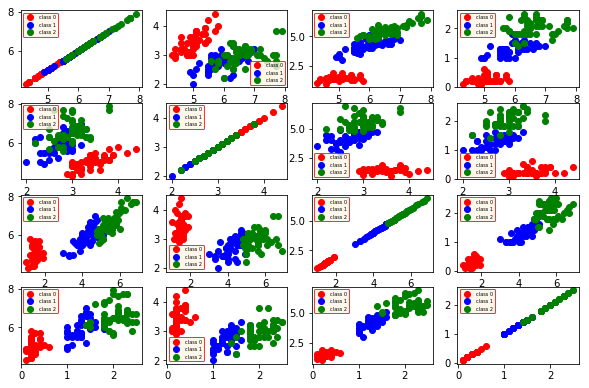

In [5]:
train_x, train_y, test_x, test_y = create_dataset()
visualize_dataset(train_x, train_y)
# print(train_y)

In [6]:
hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'SGD',
               'init_learning_rate': 0.05,
               'decay': 0.01,
               'print_log': True,
               'log_every': 1,
               'warm_start': False
               }
steps = range(1, 102, 10)
print(steps)

test_acc, test_loss = [], []

for step in steps:

    learner = CircuitLearner(hyperparams=hyperparams)

    learner.train_circuit(X=train_x, Y=train_y, steps=step, batch_size=batch_size)

    test_score = learner.score_circuit(X=test_x, Y=test_y,
                                       outputs_to_predictions=outputs_to_predictions)
    
    test_acc.append(test_score['accuracy'])
    test_loss.append(test_score['loss'])
    

range(1, 102, 10)

----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.01
init_learning_rate - 0.05
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - SGD
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_task_id': 0, '_model_dir': 'logsAUTO', '_num_worker_replicas': 1, '_is_chief': True, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_master': '', '_session_config': None, '_num_ps_replicas': 0, '_service': None, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_log_step_count_steps':

ValueError: No gradients provided for any variable: ['<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed390>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed3c8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed400>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed438>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed780>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed5f8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264edb70>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed6d8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed588>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed828>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed7f0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed898>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed4a8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264eddd8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264ed5c0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f202648a668>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f202648af98>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f202648abe0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f202648afd0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f202648af60>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a80f0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a82b0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8128>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a82e8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8320>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8358>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8390>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a83c8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8400>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8438>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8470>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a84a8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a84e0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8518>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8550>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8588>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a85c0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a85f8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8630>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8668>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a86a0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a86d8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8710>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8748>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a8780>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f20264a87b8>'].